Epoch [1/10], Train Loss: 0.1691, Val Loss: 0.0721
Epoch [2/10], Train Loss: 0.0793, Val Loss: 0.0632
Epoch [3/10], Train Loss: 0.0651, Val Loss: 0.0408
Epoch [4/10], Train Loss: 0.0632, Val Loss: 0.0534
Epoch [5/10], Train Loss: 0.0600, Val Loss: 0.0474
Epoch [6/10], Train Loss: 0.0588, Val Loss: 0.0450
Epoch [7/10], Train Loss: 0.0554, Val Loss: 0.0568
Epoch [8/10], Train Loss: 0.0545, Val Loss: 0.0430
Epoch [9/10], Train Loss: 0.0552, Val Loss: 0.0469
Epoch [10/10], Train Loss: 0.0553, Val Loss: 0.0362


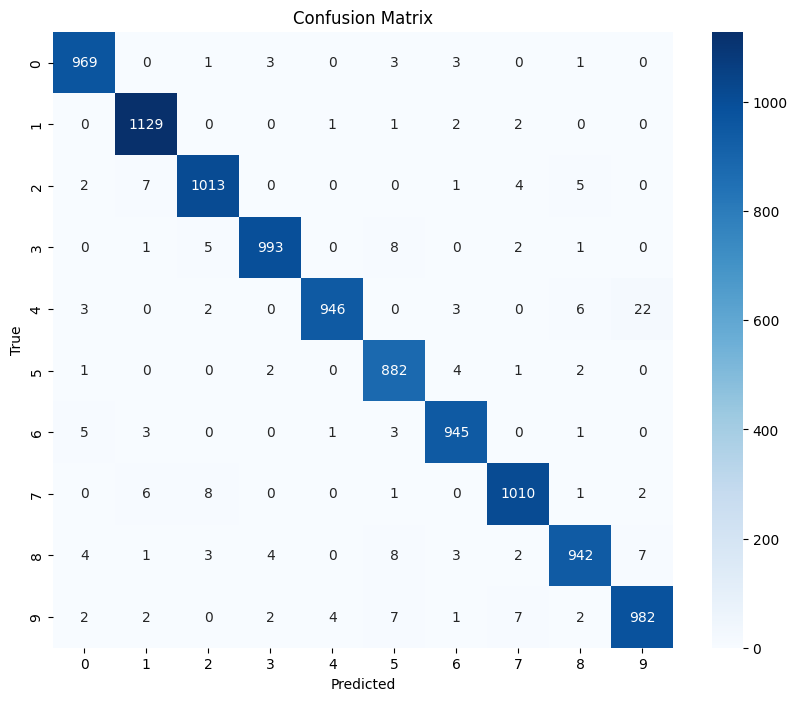

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

val_size = int(0.1 * len(trainset))
indices = list(range(len(trainset)))
np.random.shuffle(indices)
train_idx, val_idx = indices[val_size:], indices[:val_size]


trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2)
        self.fc1 = nn.Linear(32 * 6 * 6, 64)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

train_losses = []
val_losses = []
best_val_loss = float('inf')


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(trainloader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    for inputs, labels in valloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
    val_loss = running_loss / len(valloader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    model.eval()

all_preds = torch.tensor([])
all_labels = torch.tensor([])

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()